In [1]:
import torch
import glob
import pytorch_lightning as pl
from ClimatExML.loader import ClimatExMLData
from ClimatExML.wgan_gp import SuperResolutionWGANGP
from lightning.pytorch.tuner import Tuner
import matplotlib.pyplot as plt
import xarray as xr

# torch.set_float32_matmul_precision('medium')
torch.set_float32_matmul_precision('medium')
torch.cuda.empty_cache()

In [46]:
ds = xr.open_dataset("ME.nc").ME
grid = xr.open_dataset("/home/nannau/data/wrf/U10_200010.nc")
rds = regrid_align(ds, grid)

/home/nannau/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/xarray/core/dataarray.py:854: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [47]:
rds

<xarray.DataArray (rlat: 699, rlon: 639)>
array([[  0.      ,   0.      ,   0.      , ..., 578.83466 , 563.53357 ,
        556.04425 ],
       [  0.      ,   0.      ,   0.      , ..., 564.9245  , 554.9384  ,
        548.5771  ],
       [  0.      ,   0.      ,   0.      , ..., 552.88806 , 547.38245 ,
        542.1449  ],
       ...,
       [123.51739 , 126.45593 , 129.8126  , ..., 138.16173 , 124.31091 ,
        107.40679 ],
       [113.62971 , 118.65766 , 123.12351 , ..., 117.47294 , 106.93812 ,
         93.3429  ],
       [101.55109 , 108.30455 , 115.212746, ..., 103.33816 ,  94.76821 ,
         84.24956 ]], dtype=float32)
Coordinates:
    lon      (rlat, rlon) float32 -133.3 -133.3 -133.2 ... -83.25 -83.16 -83.08
    lat      (rlat, rlon) float32 46.09 46.1 46.11 46.12 ... 69.57 69.55 69.53
Dimensions without coordinates: rlat, rlon
Attributes:
    regrid_method:  bilinear

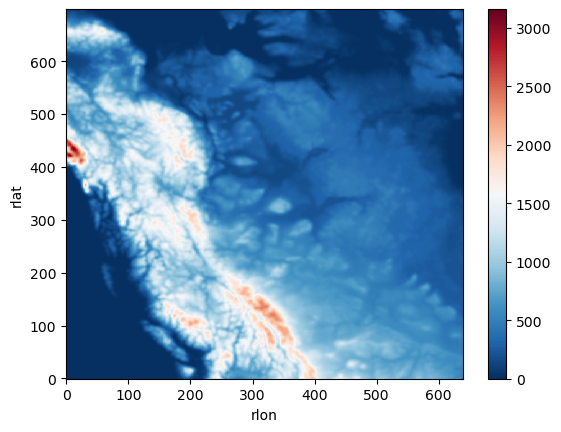

In [44]:
rds.plot(cmap="RdBu_r")

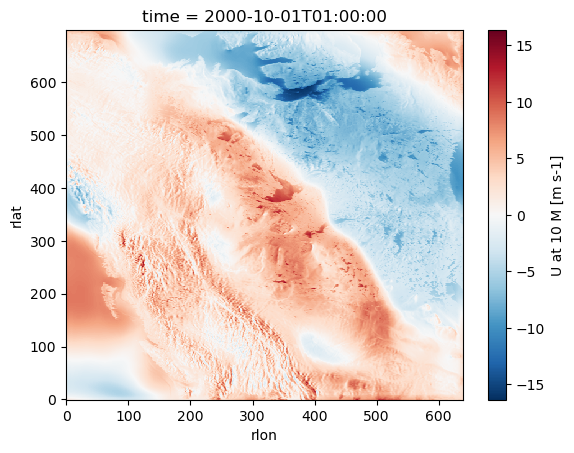

In [50]:
grid.U10[1, ...].plot()

In [35]:
from ClimatExPrep.preprocess_helpers import regrid_align

ds = xr.open_dataset("uvic_d03_2020-09-01_07_00_00")
ds = ds.rename({"XLAT": "lat", "XLONG": "lon", "south_north": "rlon", "west_east": "rlat"}).HGT[0, ...]

grid = xr.open_dataset("/home/nannau/data/wrf/U10_200010.nc")
rds = regrid_align(ds, grid)
# ds.HGT.plot()
rds

/home/nannau/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/xarray/core/dataarray.py:854: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


<xarray.DataArray (rlat: 699, rlon: 639)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    lon      (rlat, rlon) float32 -133.3 -133.3 -133.2 ... -83.25 -83.16 -83.08
    lat      (rlat, rlon) float32 46.09 46.1 46.11 46.12 ... 69.57 69.55 69.53
Dimensions without coordinates: rlat, rlon
Attributes:
    regrid_method:  bilinear

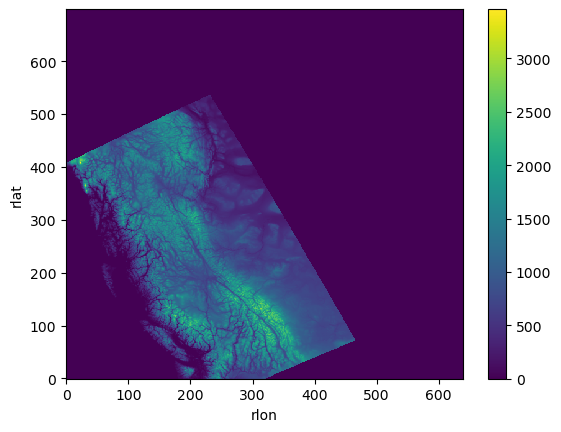

In [36]:
rds.plot()

In [2]:
data_glob = {
    "lr_test": [
        glob.glob("/home/nannau/data/era5/test/U10/*.pt"),
        glob.glob("/home/nannau/data/era5/test/V10/*.pt"),
        glob.glob("/home/nannau/data/era5/test/ps/*.pt")
    ],
    "lr_train": [
        glob.glob("/home/nannau/data/era5/train/U10/*.pt"),
        glob.glob("/home/nannau/data/era5/train/V10/*pt"),
        glob.glob("/home/nannau/data/era5/train/ps/*.pt")
    ],
    "lr_train": [
        glob.glob("/home/nannau/data/era5/train/U10/*.pt"),
        glob.glob("/home/nannau/data/era5/train/V10/*.pt"),
        glob.glob("/home/nannau/data/era5/train/ps/*.pt")
    ],
    "hr_test": [
        glob.glob("/home/nannau/data/wrf/test/U10/*.pt"),
        glob.glob("/home/nannau/data/wrf/test/V10/*.pt"),
    ],
    "hr_train": [
        glob.glob("/home/nannau/data/wrf/train/U10/*.pt"),
        glob.glob("/home/nannau/data/wrf/train/V10/*.pt"),
    ]
}

In [3]:
len("/home/nannau/data/wrf/train/U10/")
data_glob["hr_train"][0][0][:len("/home/nannau/data/wrf/train/U10/")]

'/home/nannau/data/wrf/train/U10/'

In [4]:
# for key, value in data_glob.items():
#     print(f"Key {key}")
# Fix indexing of list
globed = []
# for L in data_glob["hr_train"]:
L = data_glob["hr_train"][1]
print(len(L))
try:
    print("Checking if any are NaN")
    tlist = [torch.any(torch.isnan(torch.load(f"{L[0][:32]}/V10_{i}.pt"))) for i, x in enumerate(L)]
    nancheck = torch.tensor(tlist)
    globed.append([i for i, x in enumerate(tlist) if x])
    assert not torch.any(nancheck), f"Sum: {sum(nancheck)}, at {tlist.index(True)}"
except AssertionError:
    print(f"Sum: {sum(nancheck)}, at {globed}")


111685
Checking if any are NaN


In [18]:
#Checking if any are NaN
#Sum: 11, at [[111685, 111686, 111687, 111688, 111689, 111690, 111691, 111692, 111693, 111694, 111695]]



111685

In [19]:
torch.any(torch.isnan(torch.load(f"/home/nannau/data/wrf/train/U10/U10_{globed[0][0]}.pt")))

tensor(True)

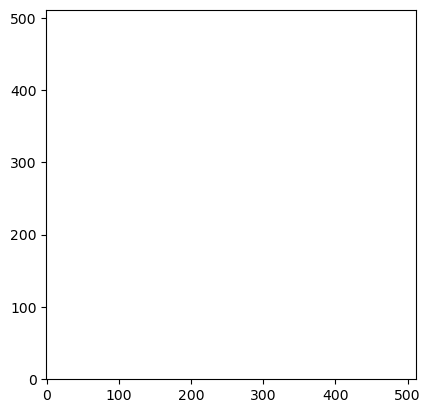

In [21]:
plt.imshow(torch.load(f"/home/nannau/data/wrf/train/U10/U10_{globed[0][0]}.pt"), origin="lower")

In [44]:
ds = xr.open_mfdataset("/brain/scratch/climatex_data/wrf/U10/*.nc", engine="h5netcdf")

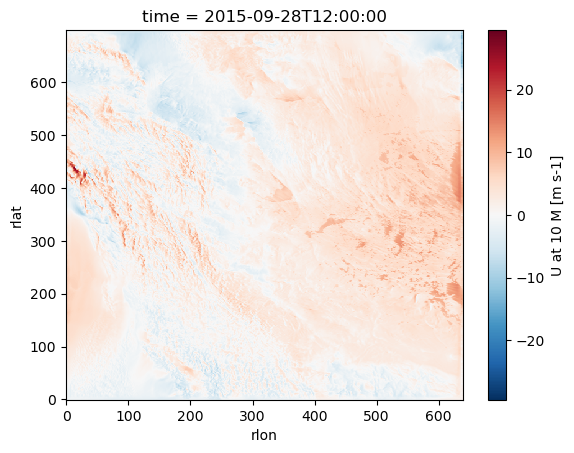

In [53]:
ds.sel(time='2015-09-28T12:00:00.000000000').U10.plot()

In [43]:
dsz = xr.open_zarr("/home/nannau/data/wrf/train_hr.zarr/")

dsz.time[globed[0]].values

array(['2015-09-28T13:00:00.000000000', '2015-09-28T14:00:00.000000000',
       '2015-09-28T15:00:00.000000000', '2015-09-28T16:00:00.000000000',
       '2015-09-28T17:00:00.000000000', '2015-09-28T18:00:00.000000000',
       '2015-09-28T19:00:00.000000000', '2015-09-28T20:00:00.000000000',
       '2015-09-28T21:00:00.000000000', '2015-09-28T22:00:00.000000000',
       '2015-09-28T23:00:00.000000000'], dtype='datetime64[ns]')

In [12]:
import numpy as np
start = "20001001T01:00:00"
end = "20150929T23:00:00"
nds = ds.sel(time=slice(start, end), drop=True)
# np.any(np.isnan(nds.U10[globed[1], ...].values))

In [16]:
import multiprocessing
dsz = xr.open_zarr("/home/nannau/data/wrf/train_hr.zarr/")
isnull = dsz.U10.isnull()

def extract_any_nan(x):
    return x.values.any()

print("Isnull List!")
isnull_list = [x for x in isnull]

print("Starting mp loop")
# create a process pool that uses all cpus
if __name__ == '__main__':

    with multiprocessing.Pool() as pool:
        # call the function for each item in parallel, get results as tasks complete
        results = []
        # for result in pool.imap(extract_any_nan, isnull_list):
        #     results.append(result)
        for result in pool.map(extract_any_nan, isnull_list):
            results.append(result)

Isnull List!
Starting mp loop


Process ForkPoolWorker-92:
Process ForkPoolWorker-93:
Process ForkPoolWorker-82:
Process ForkPoolWorker-78:
Process ForkPoolWorker-96:
Process ForkPoolWorker-75:
Process ForkPoolWorker-95:
Process ForkPoolWorker-79:
Process ForkPoolWorker-73:
Process ForkPoolWorker-89:
Process ForkPoolWorker-76:
Process ForkPoolWorker-94:
Process ForkPoolWorker-74:
Process ForkPoolWorker-90:
Process ForkPoolWorker-77:
Process ForkPoolWorker-88:
Process ForkPoolWorker-87:
Process ForkPoolWorker-80:
Process ForkPoolWorker-86:
Process ForkPoolWorker-84:
Process ForkPoolWorker-85:
Process ForkPoolWorker-91:
Process ForkPoolWorker-83:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-81:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Tr

KeyboardInterrupt: 

In [8]:
idxs = [i for i, x in enumerate(results) if x]

In [30]:
f = 4
nds.U10[idxs, ...][f].values.max(), nds.U10[idxs, ...][f].values.min()

(95.35563, -18.865618)

In [39]:
# np.any(np.isnan(dsz.U10[idxs, ...][f].values))
dsz.U10[idxs, ...][f].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [44]:
# nds.U10[idxs, ...][f].plot(vmin=-10, vmax=10)
nds.sel(time="20150928T17:00:00").U10.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

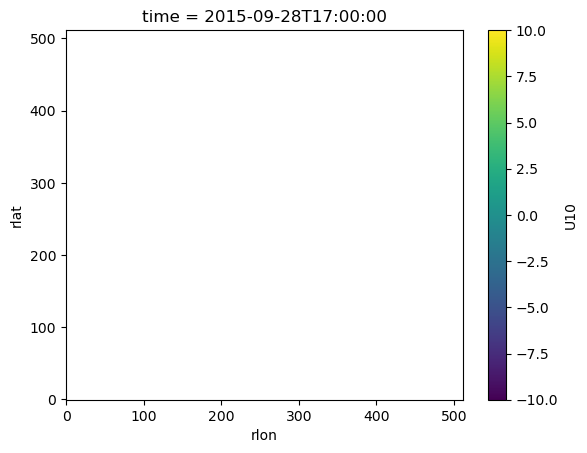

In [35]:
dsz.U10[idxs, ...][f].plot(vmin=-10, vmax=10)

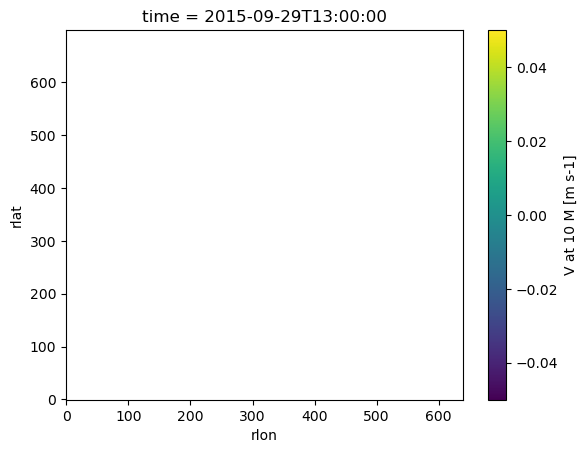

In [72]:
xr.open_dataset("/home/nannau/data/wrf/V10_201509.nc").V10[-11, ...].plot()

In [74]:
xr.open_dataset("/home/nannau/data/wrf/U10_201509.nc").U10[-13, ...].time

<xarray.DataArray 'time' ()>
array('2015-09-29T11:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2015-09-29T11:00:00
Attributes:
    standard_name:  time
    axis:           T

In [34]:
sum(nds.U10[idxs, ...][f].values.flatten() > 90)

1

In [17]:
nds.time[idxs]

<xarray.DataArray 'time' (time: 22)>
array(['2013-06-28T14:00:00.000000000', '2013-06-28T15:00:00.000000000',
       '2013-06-28T16:00:00.000000000', '2013-06-28T17:00:00.000000000',
       '2013-06-28T18:00:00.000000000', '2013-06-28T19:00:00.000000000',
       '2013-06-28T20:00:00.000000000', '2013-06-28T21:00:00.000000000',
       '2013-06-28T22:00:00.000000000', '2013-06-28T23:00:00.000000000',
       '2013-06-29T00:00:00.000000000', '2013-06-29T14:00:00.000000000',
       '2013-06-29T15:00:00.000000000', '2013-06-29T16:00:00.000000000',
       '2013-06-29T17:00:00.000000000', '2013-06-29T18:00:00.000000000',
       '2013-06-29T19:00:00.000000000', '2013-06-29T20:00:00.000000000',
       '2013-06-29T21:00:00.000000000', '2013-06-29T22:00:00.000000000',
       '2013-06-29T23:00:00.000000000', '2013-06-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-06-28T14:00:00 ... 2013-06-30
Attributes:
    standard_name:  time
    axis:           T

In [34]:
dsz = xr.open_zarr("/home/nannau/data/wrf/train_hr.zarr/")
isnull = dsz.U10.isnull()
tselnull = [x.values.any() for x in isnull]

KeyboardInterrupt: 

In [29]:
tselnull

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [26]:
[i for i, x in enumerate(tselnull) if x]

KeyboardInterrupt: 

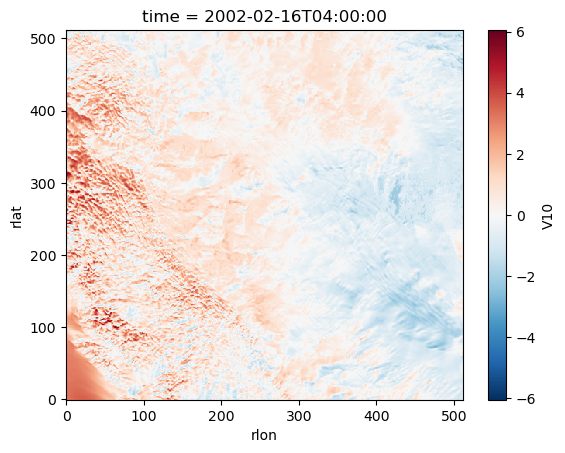

In [14]:
dsz = xr.open_zarr("/home/nannau/data/wrf/train_hr.zarr/")
dsz.V10[globed[1], ...].plot()

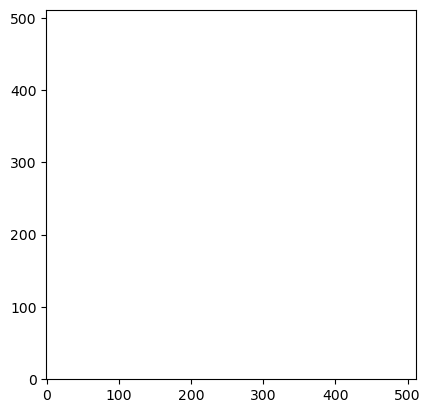

In [40]:
# torch.any(torch.isnan((torch.load(globed[4162]))))
plt.imshow(torch.load(glob.glob("/home/nannau/data/wrf/train/U10/*.pt")[globed[5]]), origin="lower")

In [3]:
from lightning.pytorch.loggers import MLFlowLogger

mlf_logger = MLFlowLogger(experiment_name="lightning_logs", tracking_uri="file:./ml-runs")
# trainer = Trainer(logger=mlf_logger)

In [4]:
srmodel = SuperResolutionWGANGP(data_glob=data_glob)
trainer = pl.Trainer(precision="16-mixed", accelerator="gpu", max_epochs=1, logger=mlf_logger, log_every_n_steps=50)#fast_dev_run=True)
# tuner = Tuner(trainer)

# Auto-scale batch size by growing it exponentially (default)
# tuner.scale_batch_size(srmodel, max_trials=1, mode="power")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(srmodel)

Traceback (most recent call last):
  File "/home/nannau/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 290, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/home/nannau/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 383, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/nannau/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1083, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/home/nannau/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1076, in _read_helper
    result = read_yaml(root, file_name)
  File "/home/nannau/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 214, in read_yaml
    raise MissingConfigExcepti

Epoch 0:  19%|█████████████████▏                                                                         | 1315/6983 [30:53<2:13:07,  1.41s/it, v_num=55af, MAE loss=0.982, MSE loss=1.630, wasserstein=2514.0]